In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import seaborn as sns
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text
from matplotlib.legend import Legend
from scipy.stats import ranksums, ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.power import TTestIndPower
import statsmodels.stats.multicomp as mc

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

import os
import json

In [43]:
with open('data/paths.json','r') as f:
    paths = json.load(f)

data_path = paths["data_path"]

In [44]:
whole = True

batch_corrected = False
zero_remove = False
use_plsd_subset = False
scaler_term = 'minmax'
scaler = MinMaxScaler() if scaler_term=='minmax' else StandardScaler()
data_col_idx = 19 if batch_corrected else 16

test_enc_name = '_BatchCor'+str(batch_corrected)+'_NanRem'+str(zero_remove)+'_'+str(scaler_term)
test_enc_name_new = '_Whole_'+str(whole)+'_ZeroRem_'+str(zero_remove)+'_PlsdSubset_'+str(use_plsd_subset)

In [45]:
# with open(os.path.join('results','significant_lipids_pls2_treatment'+test_enc_name_new+'.txt'),'r') as f:
#     lipids_names = f.read().splitlines()
# print(lipids_names)
# print(len(lipids_names))

In [46]:
sns.set(style = 'whitegrid')

### Load Data

In [47]:
data_new = pd.read_excel(os.path.join(data_path,"20240109_lipidomics_data.xlsx"),sheet_name='20240109_lipidomics_data')
if whole:
    data_old = pd.read_excel(os.path.join(data_path,"2022_12_Laezza_Mouse_Brain_deltamethrin_COMBINED_LIPIDOMICS_bc.xlsx"))

    data_old = data_old[data_old['Sample Submission Date'] == '11/2022']
    data_old = data_old[data_old['Sex']=='M']
    data_old = data_old[data_old['Tissue Type']=='striatum']
    data_old = data_old[data_old['PND']==30]

columns_data = ['LCMS Name', 'Tissue Weight\n(mg)', 'Treatment', 'Lipid Name','Lipid Class','Normalized Peak Area (Peak Area of Lipid/ (Peak Area of Internal Standard * Tissue weight))']
columns_old = ['Sample Name', 'Tissue weight (mg)', 'Treatment', 'Individual Lipid Species', 'Lipid Class', 'Normalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue Weight))']
columns_new = ['name','weight','treatment','lipid','lipid_class','area']

data_new = data_new[columns_data]
data_new.columns = columns_new
data_new['batch']=1

if whole:
    data_old = data_old[columns_old]
    data_old.columns = columns_new
    data_old['batch']=0

if whole:
    conversion_table = pd.read_excel(os.path.join(data_path,"2024_01_lipid_naming_conversion.xlsx"))

    for index, row in conversion_table.iterrows():
        if not pd.isna(row['Lipidomics version 2 equivalent name']):
            data_old.loc[data_old['lipid'] == row['Lipidomics version 1 Method'],'lipid'] = row['Lipidomics version 2 equivalent name']
        else:
            data_old.loc[data_old['lipid'] == row['Lipidomics version 1 Method'],'lipid'] = row['Lipidomics version 1 Method']

    # We want to keep just the lipids that are common among the two batches
    common_lipids = conversion_table['Lipidomics version 2 equivalent name'].unique()
    data_old = data_old[data_old['lipid'].isin(common_lipids)]

if whole:
    data_all = pd.concat([data_new, data_old], axis=0)
    data_all = data_all[data_all['area']!=0]
else:
    data_all = data_new.copy()

if zero_remove:
    data_all = data_all[data_all['area'] > 0]
else:
    corrfac = np.min(np.abs(data_all['area'][data_all['area']>0]))
    data_all[data_all['area'] <= 0] = corrfac

if use_plsd_subset:
    data_all = data_all[data_all['lipid'].isin(lipids_names)].copy(deep=True)
      
data_all['area_org'] = data_all['area'].copy(deep=True)
data_all['area'] = np.log(data_all['area'])

In [48]:
data_all.to_csv("test.csv", index=False)

In [49]:
data_all = data_all[data_all['name'] != '20231228_Laezza_Lipidomics_PQC #6']

In [50]:
data_all['treatment'] = LabelEncoder().fit_transform(data_all['treatment'])
data_all.head()

,name,weight,treatment,lipid,lipid_class,area,batch,area_org
20,20231228_Laezza_Lipidomics_#1,106,0,CE(16:0),CE,-5.316481,1,0.00491
21,20231228_Laezza_Lipidomics_#2,82,0,CE(16:0),CE,-4.518992,1,0.01090
22,20231228_Laezza_Lipidomics_#3,92,0,CE(16:0),CE,-4.976234,1,0.00690
23,20231228_Laezza_Lipidomics_#4,105,0,CE(16:0),CE,-5.091303,1,0.00615
24,20231228_Laezza_Lipidomics_#5,100,0,CE(16:0),CE,-5.621281,1,0.00362


# FIGURES

### Violin Plots

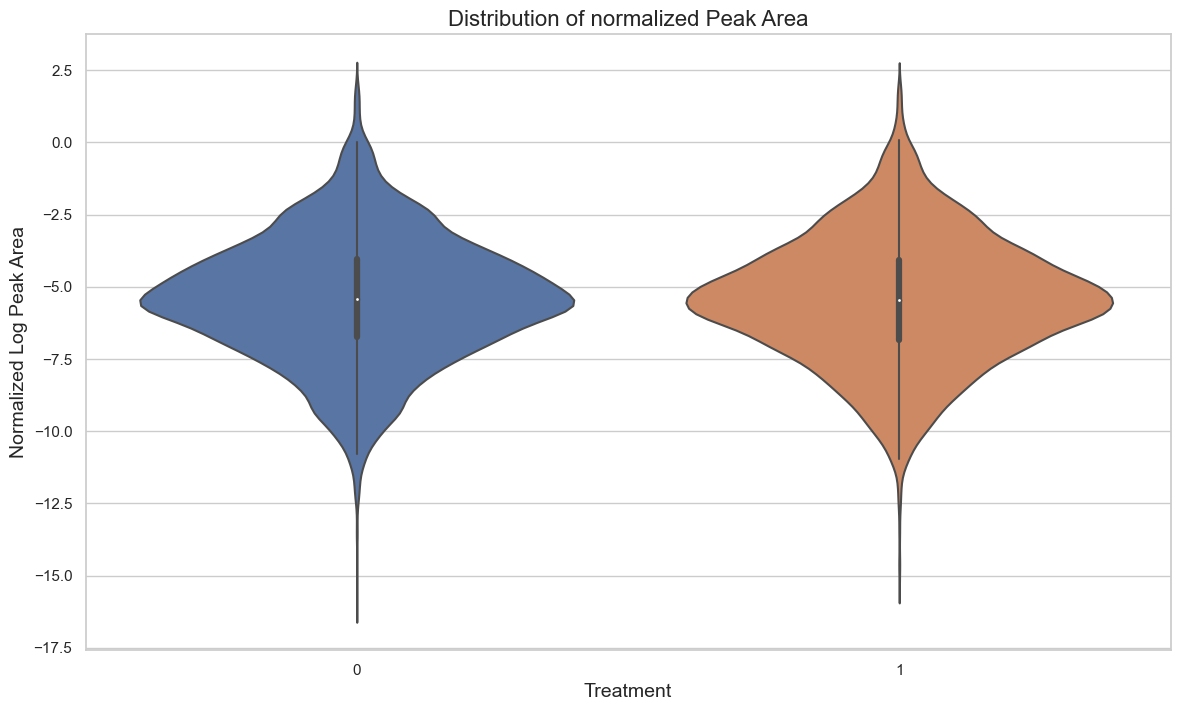

In [51]:
fig = plt.figure(figsize=(14,8), dpi=100)
ax = sns.violinplot(data=data_all, x='treatment', y='area',split=True, inner='box')

ax.set_title('Distribution of normalized Peak Area', fontsize=16)
ax.set_xlabel('Treatment', fontsize=14)
ax.set_ylabel('Normalized Log Peak Area', fontsize=14)

fig.savefig(os.path.join(data_path,"lipids_violinplot"+test_enc_name_new+".png"), format='png', facecolor='w')

### Histograms

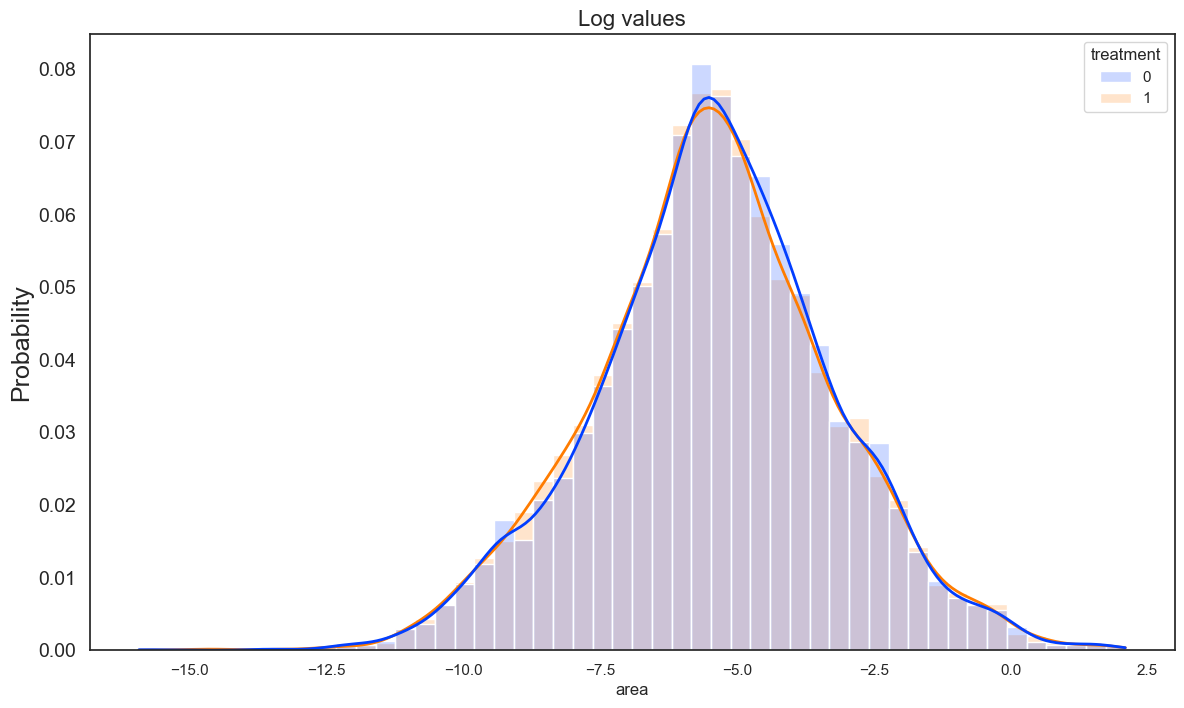

In [52]:
sns.set_style('white')

fig, axs = plt.subplots(figsize=(14,8))

opt = {'bins': 50, 'alpha': 0.2, 'palette': 'bright',
        'stat': 'probability', 'kde': True,
        'line_kws': {'lw': 2}, 'common_norm': False}

sns.histplot(data=data_all, x='area', hue='treatment', ax=axs, legend=True, **opt)
axs.set_title('Log values', fontsize=16)
axs.set_ylabel('Probability', fontsize=18)
axs.tick_params(axis='y', labelsize=14)

fig.savefig(os.path.join(data_path,"lipids-distribution-3cases-no-date"+test_enc_name_new+".png"), format='png', facecolor='w', dpi=300)

plt.show()

### PLOTS

In [53]:
def adjustlabels(fig, labels, max_iter=1000, eps=0.01, delta=0.1, 
                 clip_to_axes=True, pad=0.1):
    N = len(labels)
    widths = np.zeros(N)
    heights = np.zeros(N)
    centers = np.zeros((N, 2))
    for i,l in enumerate(labels):
        bb = l.get_window_extent(renderer=fig.canvas.get_renderer())
        bb = bb.transformed(plt.gca().transData.inverted())
        widths[i] = bb.width
        heights[i] = bb.height
        centers[i] = (bb.min + bb.max)/2
        
    ylim = plt.gca().get_ylim()
    xlim = plt.gca().get_xlim()    

    def clip():
        for i in range(N):
            centers[i,0] = max(centers[i,0], xlim[0] + widths[i]/2 + pad)
            centers[i,0] = min(centers[i,0], xlim[1] - widths[i]/2 - pad)
            centers[i,1] = max(centers[i,1], ylim[0] + heights[i]/2 + pad)
            centers[i,1] = min(centers[i,1], ylim[1] - heights[i]/2 - pad)
            labels[i].set_position(centers[i])
    clip()

    for i in range(max_iter):
        stop = True
        for a in range(N):
            for b in range(N):
                if ((a!=b) and
                    (np.abs(centers[a,0]-centers[b,0]) < (widths[a]+widths[b])/2 + delta) and
                    (np.abs(centers[a,1]-centers[b,1]) < (heights[a]+heights[b])/2 +  delta)):
                    
                    d = centers[a] - centers[b]
                    centers[a] += d * eps
                    centers[b] -= d * eps
                    labels[a].set_position(centers[a])
                    labels[b].set_position(centers[b])
                    if clip_to_axes:
                        clip()
                    stop = False
        if stop:
            break

In [54]:
def plot_volcano(results_all, fc_threshold=0.3, pvalue_threshold=1.5, filename="test.png"):

    class TextHandlerB(HandlerBase):
        def create_artists(self, legend, text ,xdescent, ydescent,
                            width, height, fontsize, trans):
            tx = Text(width/2.,height/2, text, fontsize=fontsize,
                    ha="center", va="center", fontweight="bold")
            return [tx]

    Legend.update_default_handler_map({str : TextHandlerB()})       
    
    #col = np.where(np.log2(results_all['fc']) < -fc_threshold,'r',np.where(np.log2(results_all['fc']) > fc_threshold,'g','k'))
    col = np.where(-np.log10(results_all['p']) < pvalue_threshold, 'k', 
                            np.where(np.log2(results_all['fc']) < -fc_threshold,'r',np.where(np.log2(results_all['fc']) > fc_threshold,'g','k')))

    fig = plt.figure(figsize=(16,12))
    plt.scatter(np.log2(results_all['fc']), -np.log10(results_all['p']), c=col)
    y_max_value = plt.gca().get_ylim()[1]
    shownlabels = []
    l_ha = ['right','left']
    elem_counter = 1
    legend_data_handles = []
    legend_data_labels = []
    for i in range(results_all.shape[0]): 

        x = np.log2(results_all.iloc[i]['fc'])
        y = -np.log10(results_all.iloc[i]['p'])
        aa = np.random.rand()*3 - 1.5 + 0.5 * np.sign(x)
        ii = np.sign(aa) * 0.5 + 0.5
        if (np.abs(x) > fc_threshold) and (y > pvalue_threshold):
            l = plt.text(x, y + 0.03*y_max_value, elem_counter, va='center', color='k', fontsize=14, zorder=10,bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.1))
            """ l = plt.text(x+0.01*aa, y,
                         results_all.iloc[i]['lipid'],ha=l_ha[int(ii)], va='center', color='k', 
                         fontsize=10, zorder=10,bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.2)) """
            #shownlabels.append(l)
            legend_circle = Line2D([0], [0], marker='o', color='w', markerfacecolor='r' if x < -fc_threshold else 'g', markersize=10)
            legend_data_handles.append(legend_circle)
            legend_data_labels.append(str(elem_counter) + '-' + results_all.iloc[i]['lipid'])
            #legend_data_keeper.update({str(elem_counter): results_all.iloc[i]['lipid']})
            elem_counter += 1
    #adjustlabels(fig, shownlabels)
    plt.legend(handles=legend_data_handles,labels=legend_data_labels, loc='upper left', bbox_to_anchor=(1, 0.5), title='Legend')
    plt.xlabel('log FC',)
    plt.ylabel('-log10 (Pvalue)')
    plt.rc('axes', labelsize=18) 
    fig.savefig(os.path.join(data_path,filename), format='png', facecolor='w', dpi=400, bbox_inches = 'tight')

    plt.show()

#### Let's prepare the data for the volcano plot

In [55]:
lipids_list = data_all['lipid'].unique()
len(lipids_list)

1293

In [56]:
import itertools
factor = 'treatment'
results_all = []
for l in lipids_list:
    data_metabolite = data_all[data_all['lipid'] == l]
    if data_metabolite[factor].unique().size > 1: # Some metabolties are not found in both classes
        for c in itertools.combinations(data_metabolite[factor].unique(),2):
            a = data_metabolite[data_metabolite[factor] == c[0]]['area'].values
            b = data_metabolite[data_metabolite[factor] == c[1]]['area'].values
            aa = data_metabolite[data_metabolite[factor] == c[0]]['area_org'].values
            bb = data_metabolite[data_metabolite[factor] == c[1]]['area_org'].values
            pvalue = ttest_ind(a,b)[1]
            # pvalue = ranksums(a,b).pvalue
            fc = np.mean(aa)/np.mean(bb)
            cd = np.abs((np.mean(a) - np.mean(b)))
            cd /= np.sqrt(
                ((a.size - 1)*np.var(a) + (b.size - 1)*np.var(b)) / (a.size + b.size - 2)
            )
            n_samples = a.size
            sp = TTestIndPower().power(effect_size=cd, nobs1=n_samples, alpha=0.05)
            results_all.append([l, fc, pvalue, c[0], c[1], cd, n_samples, sp])

colnames = ['lipid', 'fc', 'p', factor+'1', factor+'2', 'effectSize', 'sampleSize', 'statisticalPower']
results_all = pd.DataFrame(data=results_all, columns= colnames)
results_all.head()

/Users/simone/.pyenv/versions/3.11.0/envs/brisk/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/Users/simone/.pyenv/versions/3.11.0/envs/brisk/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/var/folders/15/_htnf9m52ys2vzcf0_z47qnc0000gn/T/ipykernel_70659/751739204.py:12: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  pvalue = ttest_ind(a,b)[1]
/Users/simone/.pyenv/versions/3.11.0/envs/brisk/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/simone/.pyenv/versions/3.11.0/envs/brisk/lib/pytho

,lipid,fc,p,treatment1,treatment2,effectSize,sampleSize,statisticalPower
0,CE(16:0),NaN,NaN,0,1,NaN,13,NaN
1,CE(16:1),NaN,NaN,0,1,NaN,13,NaN
2,CE(18:1),NaN,NaN,0,1,NaN,13,NaN
3,CE(18:2),NaN,NaN,0,1,NaN,13,NaN
4,CE(20:4),0.695792,0.759022,0,1,0.126674,13,0.061097


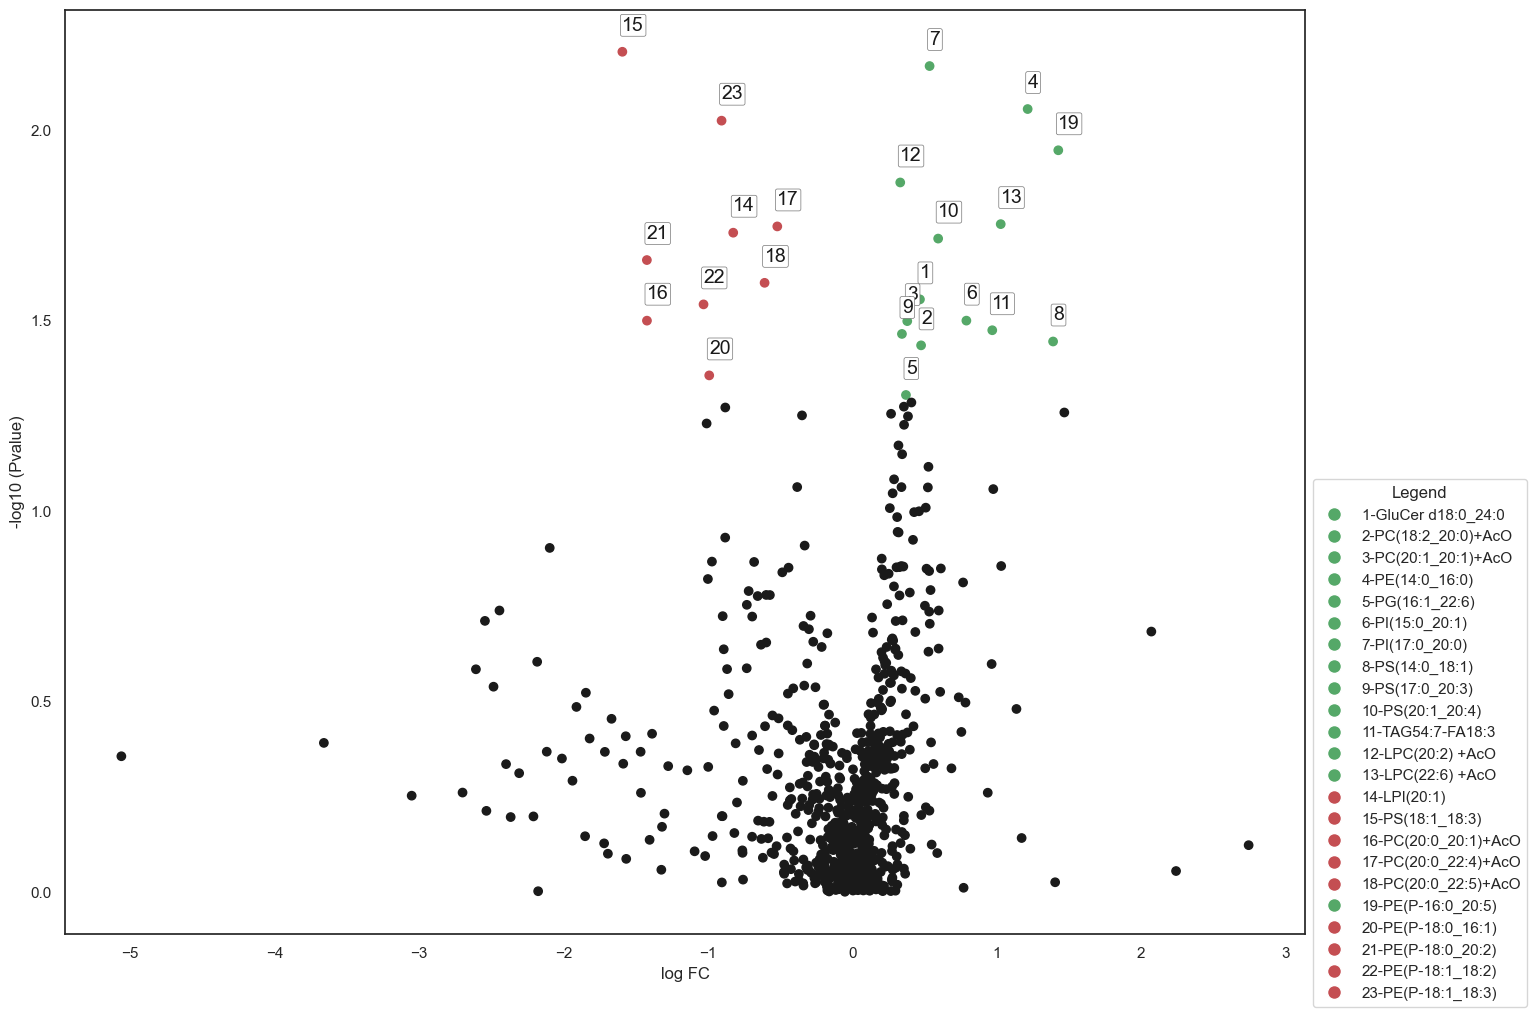

In [57]:
plot_volcano(results_all,fc_threshold=0.1, pvalue_threshold=1.3, filename="lipids-volcano-plot-treatment"+test_enc_name_new+".png")

# STATISTICS

### Wilcoxon test

In [58]:
var_name = 'area'

a = data_all[data_all['treatment'] == 0][var_name]
b = data_all[data_all['treatment'] == 1][var_name]

a = a.dropna()
b = b.dropna()

print(f'P-value: {ranksums(a,b).pvalue:.2e}')

P-value: 6.45e-02


### T-test

In [59]:
var_name = 'area'

a = data_all[data_all['treatment'] == 0][var_name]
b = data_all[data_all['treatment'] == 1][var_name]

a = a.dropna()
b = b.dropna()

print(f'P-value: {ttest_ind(a,b).pvalue:.2e}')

P-value: 1.22e-01


In [60]:
from scipy.stats import ranksums, ttest_ind

res = []
for t in np.unique(data_all['lipid']):
    data_part = data_all[data_all['lipid'] == t]
    a = data_part[data_part['treatment'] == 0]['area'].values
    b = data_part[data_part['treatment'] == 1]['area'].values
    p_t = ttest_ind(a,b).pvalue
    p_r = ranksums(a,b).pvalue
    res.append([t, len(a), len(b), p_t, p_r, np.mean(a)<np.mean(b)])

res = pd.DataFrame(res)
res.columns=['lipid','n_control', 'n_treated', 'p_ttest', 'p_ranksum', 'upregulated']
res = res[(res['p_ttest']<0.05) | (res['p_ranksum']<0.05)]
res.to_csv(os.path.join('data', 'results_lipid_whole_' + str(whole) + '.csv'))
print(f'{res.shape[0]} significant metabolites')

/Users/simone/.pyenv/versions/3.11.0/envs/brisk/lib/python3.11/site-packages/scipy/stats/_stats_py.py:8504: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Users/simone/.pyenv/versions/3.11.0/envs/brisk/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/simone/.pyenv/versions/3.11.0/envs/brisk/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/15/_htnf9m52ys2vzcf0_z47qnc0000gn/T/ipykernel_70659/3466546235.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  p_t = ttest_ind(a,b).pvalue
/Users/simone/.pyenv/versions/3.11.0/envs/brisk/lib/python3.11/site-packages/scipy/stats/_stats_py.

29 significant metabolites
